
# Dataset split train and test with timeseries generator

## Import libraries

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load
import h5py
import random

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D 
from keras.callbacks import ModelCheckpoint

from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # True dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Scikit-learn version {}.'.format(sklearn.__version__))
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

Notebook running on Python 3.7.4
Numpy version 1.18.4
Scikit-learn version 0.23.1.
Keras version  2.4.0 and TensorFlow 2.3.0 (CUDA: True - GPUs available: [] )


## Define global variables
Such as object dimension and dataset properties

In [2]:
dimX, dimY, dimZ = 117, 86, 38
n_cells = dimX * dimY * dimZ
dims = (dimX, dimY, dimZ)
n_channels = 3
n_input = 3
n_output = 10
n_batch = 8
leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

## Load data from files
Data is filtered and reshaped for scaling.
First 200 samples are kept, while the rest of them are thirded.


In [3]:
tsini=0
tsend=200
basepath = "/home/bsc21/bsc21334/SCRATCH/aina-data/"
pathnpz = basepath + "/NPZs/"
targetname = "/case3.5.npz"
#path = basepath + "/MODEL-%d-%d/" % (tsini, tsend)
path = basepath + "/MODCHAN%d-%d-%d/" % (n_output, tsini, tsend)
if not os.path.exists(path):
    os.mkdir(path)
datapath = basepath + "/DATAFULL-%d-%d/" % (tsini, tsend)
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [29]:
%%time
caseindex = []
samples_per_case = []
ds = []
files = glob.glob(pathnpz + "*.npz")
random.seed(0)
random.shuffle(files)
#print(files)
for filename in files:
        #if int(filename.split("/")[-1].split(".")[0][-1]) > 3:
        #    continue
        #if filename == pathnpz + targetname:
        #    continue       
        #print(filename)
        caseid = filename.split("/")[-1].split(".npz")[0].split("case")[-1]
        print("Loading case", caseid)
        caseindex.append(caseid)
        dsaux = np.load(filename)
        dsaux = np.array(dsaux.f.data[tsini:tsend], dtype=np.float32)
        print(dsaux.shape)
        samples_per_case.append(len(dsaux))
        ds.append(dsaux.reshape(dsaux.shape[0] * dsaux.shape[1] * dsaux.shape[2] * dsaux.shape[3], dsaux.shape[4]))
        #print(ds[-1].shape)
        
ds = np.array(ds)
ds = np.concatenate(ds, axis=0)
print(ds.shape)
print(len(caseindex))
print(caseindex)

Loading case 4.1
(200, 117, 86, 38, 3)
Loading case 4.4
(200, 117, 86, 38, 3)
Loading case 3.2
(200, 117, 86, 38, 3)
Loading case 3.7
(200, 117, 86, 38, 3)
Loading case 3.9
(200, 117, 86, 38, 3)
Loading case 4.8
(200, 117, 86, 38, 3)
Loading case 4.2
(200, 117, 86, 38, 3)
Loading case 5.0
(200, 117, 86, 38, 3)
Loading case 6.0
(200, 117, 86, 38, 3)
Loading case 3.0
(200, 117, 86, 38, 3)
Loading case 4.5
(200, 117, 86, 38, 3)
Loading case 3.1
(200, 117, 86, 38, 3)
Loading case 3.6
(200, 117, 86, 38, 3)
Loading case 5.7
(200, 117, 86, 38, 3)
Loading case 3.8
(200, 117, 86, 38, 3)
Loading case 5.4
(200, 117, 86, 38, 3)
Loading case 5.9
(200, 117, 86, 38, 3)
Loading case 4.0
(200, 117, 86, 38, 3)
Loading case 5.1
(200, 117, 86, 38, 3)
Loading case 5.6
(200, 117, 86, 38, 3)
Loading case 4.3
(200, 117, 86, 38, 3)
Loading case 4.6
(200, 117, 86, 38, 3)
Loading case 5.2
(200, 117, 86, 38, 3)
Loading case 3.4
(200, 117, 86, 38, 3)
Loading case 3.5
(200, 117, 86, 38, 3)
Loading case 5.8
(200, 11

In [30]:
print('Dataset size in memory: %0.2f GB' % (ds.nbytes / 1024**3))
np.info(ds)
#ds_ready = ds.reshape((-1, tsend - tsini,) + dims + (n_channels,))
#print(ds_ready.shape)

Dataset size in memory: 26.49 GB
class:  ndarray
shape:  (2370607200, 3)
strides:  (12, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fe49f380010
byteorder:  little
byteswap:  False
type: float32


## Fit, transform and save scalers

In [31]:
%%time

dsS = ds[:, 0]
dsS = dsS.reshape((-1, n_cells))
print("Fitting X...")
scalerX = StandardScaler()
#scalerX = MinMaxScaler()
dsS = scalerX.fit_transform(dsS)
dump(scalerX, path + "/scalerX.joblib")
print("Reshaping X...")
dsS = dsS.reshape(sum(samples_per_case), dimX, dimY, dimZ, 1)
acc = 0
dsX_ready = []
for case in range(len(samples_per_case)):
    idx_ini = acc
    acc += samples_per_case[case]
    dsX_ready.append(dsS[idx_ini:acc, :, :, :, :])  
dsX_ready=np.array(dsX_ready)

dsS = ds[:, 1]
dsS = dsS.reshape((-1, n_cells))
scalerY = StandardScaler()
#scalerY = MinMaxScaler()
print("Fitting Y...")
dsS = scalerY.fit_transform(dsS)
dump(scalerY, path + "/scalerY.joblib")
print("Reshaping Y...")
dsS = dsS.reshape(sum(samples_per_case), dimX, dimY, dimZ, 1)
acc = 0
dsY_ready = []
for case in range(len(samples_per_case)):
    idx_ini = acc
    acc += samples_per_case[case]
    dsY_ready.append(dsS[idx_ini:acc, :, :, :, :])  
dsY_ready=np.array(dsY_ready)

dsS = ds[:, 2]
dsS = dsS.reshape((-1, n_cells))
scalerZ = StandardScaler()
#scalerZ = MinMaxScaler()
print("Fitting Z...")
dsS = scalerZ.fit_transform(dsS)
dump(scalerZ, path + "/scalerZ.joblib")
print("Reshaping Z...")
dsS = dsS.reshape(sum(samples_per_case), dimX, dimY, dimZ, 1)
acc = 0
dsZ_ready = []
for case in range(len(samples_per_case)):
    idx_ini = acc
    acc += samples_per_case[case]
    dsZ_ready.append(dsS[idx_ini:acc, :, :, :, :])  
dsZ_ready=np.array(dsZ_ready)

print(dsX_ready.shape)
print(dsY_ready.shape)
print(dsZ_ready.shape)

Fitting X...
Reshaping X...
Fitting Y...
Reshaping Y...
Fitting Z...
Reshaping Z...
(31, 200, 117, 86, 38, 1)
(31, 200, 117, 86, 38, 1)
(31, 200, 117, 86, 38, 1)
CPU times: user 15min 36s, sys: 18.3 s, total: 15min 54s
Wall time: 15min 54s


In [32]:
ratio = int(len(files) * 0.8)
#print(ratio)
dsX_train = dsX_ready[:ratio]
dsX_test = dsX_ready[ratio:]
dsY_train = dsY_ready[:ratio]
dsY_test = dsY_ready[ratio:]
dsZ_train = dsZ_ready[:ratio]
dsZ_test = dsZ_ready[ratio:]
#rint(dsX_train.shape)

ds_train = []
ds_train.append(dsX_train)
ds_train.append(dsY_train)
ds_train.append(dsZ_train)
print('Dataset size in memory: %0.2f GB' % (np.array(ds_train).nbytes / 1024**3))
np.info(np.array(ds_train))

ds_test = []
ds_test.append(dsX_test)
ds_test.append(dsY_test)
ds_test.append(dsZ_test)
print('Dataset size in memory: %0.2f GB' % (np.array(ds_test).nbytes / 1024**3))
np.info(np.array(ds_test))

with h5py.File(datapath + "/train.h5", "w") as hf:
    hf.create_dataset("dataset",  data=ds_train)
with h5py.File(datapath + "/test.h5", "w") as hf:
    hf.create_dataset("dataset",  data=ds_test)

Dataset size in memory: 20.51 GB
class:  ndarray
shape:  (3, 24, 200, 117, 86, 38, 1)
strides:  (7341235200, 305884800, 1529424, 13072, 152, 4, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fdf7e800010
byteorder:  little
byteswap:  False
type: float32
Dataset size in memory: 5.98 GB
class:  ndarray
shape:  (3, 7, 200, 117, 86, 38, 1)
strides:  (2141193600, 305884800, 1529424, 13072, 152, 4, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7febf5210010
byteorder:  little
byteswap:  False
type: float32


# LOAD DATA

In [8]:
with h5py.File(datapath + "train.h5","r") as hf:
    ds_train = hf["dataset"][:]
print(ds_train.shape)

(3, 24, 200, 117, 86, 38, 1)


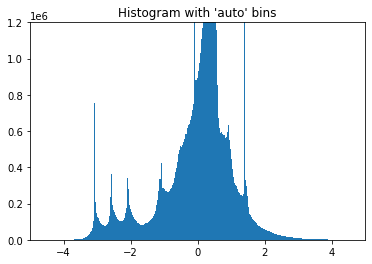

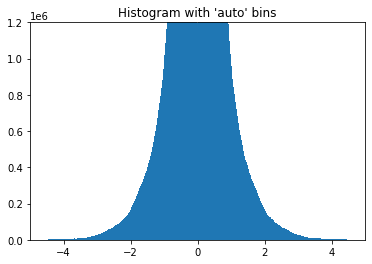

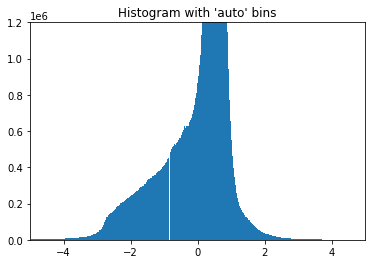

In [10]:
for c in range(3):
    ds = ds_train[c].flatten()
    #_ = plt.hist(ds, bins='auto')  # arguments are passed to np.histogram
    plt.hist(ds, bins='auto')
    plt.xlim(-5,5)
    plt.ylim(0,1200000)
    plt.title("Histogram with 'auto' bins")
    plt.show()

In [5]:
with h5py.File(datapath + "test.h5","r") as hf:
    ds_test = hf["dataset"][:]
print(ds_test.shape)

(3, 7, 200, 117, 86, 38, 1)


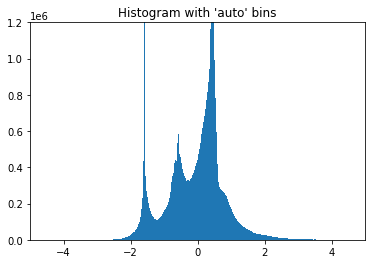

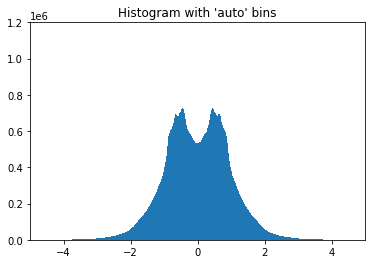

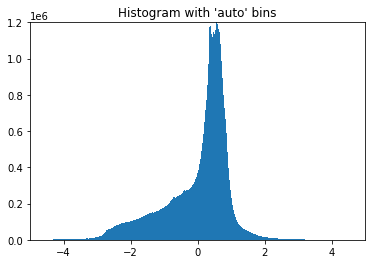

In [7]:
for c in range(3):
    ds = ds_test[c].flatten()
    #_ = plt.hist(ds, bins='auto')  # arguments are passed to np.histogram
    plt.hist(ds, bins='auto')
    plt.xlim(-5,5)
    plt.ylim(0,1200000)
    plt.title("Histogram with 'auto' bins")
    plt.show()

In [12]:
### inverse transform
pred_output = ds_ready
dsX_pred = pred_output[:,:,:,:,:,0].reshape(-1, n_cells)
dsX_pred = scalerX.inverse_transform(dsX_pred)
dsY_pred = pred_output[:,:,:,:,:,1].reshape(-1, n_cells)
dsY_pred = scalerY.inverse_transform(dsY_pred)
dsZ_pred = pred_output[:,:,:,:,:,2].reshape(-1, n_cells)
dsZ_pred = scalerZ.inverse_transform(dsZ_pred)
dsX_pred = dsX_pred.reshape((-1,) + (101,) + dims + (1,))
dsY_pred = dsY_pred.reshape((-1,) + (101,) +  dims + (1,))
dsZ_pred = dsZ_pred.reshape((-1,) + (101,) +  dims + (1,))
pred_output = np.concatenate((dsX_pred, dsY_pred, dsZ_pred), axis=5)

In [13]:
dsX_pred = dsX_pred.reshape((-1,) + (101,) + dims + (1,))
dsY_pred = dsY_pred.reshape((-1,) + (101,) +  dims + (1,))
dsZ_pred = dsZ_pred.reshape((-1,) + (101,) +  dims + (1,))
pred_output = np.concatenate((dsX_pred, dsY_pred, dsZ_pred), axis=5)

In [14]:
pred_output.shape

(11, 101, 117, 86, 38, 3)

In [15]:
pred_output[0][0]

array([[[[ 1.2242301e+00, -4.6877400e-04,  1.3536900e-02],
         [ 2.3585100e+00, -2.4623101e-04,  1.3650600e-02],
         [ 2.8892300e+00, -1.9185600e-04,  1.5657200e-02],
         ...,
         [ 5.9183502e+00, -2.8694400e-05,  2.3059700e-04],
         [ 5.9740500e+00, -2.7140200e-05, -1.2652999e-04],
         [ 6.0252500e+00, -2.5527899e-05, -2.4333299e-04]],

        [[ 1.2242301e+00, -1.2526300e-03,  1.3534000e-02],
         [ 2.3585100e+00, -7.2305999e-04,  1.3649100e-02],
         [ 2.8892300e+00, -5.7814701e-04,  1.5656400e-02],
         ...,
         [ 5.9183502e+00, -8.5191299e-05,  2.3482500e-04],
         [ 5.9740500e+00, -8.0353100e-05, -1.2402399e-04],
         [ 6.0252500e+00, -7.5852702e-05, -2.4203300e-04]],

        [[ 1.2242100e+00, -2.0889901e-03,  1.3536300e-02],
         [ 2.3585100e+00, -1.2059100e-03,  1.3654400e-02],
         [ 2.8892200e+00, -9.6368702e-04,  1.5663400e-02],
         ...,
         [ 5.9183502e+00, -1.3967601e-04,  2.4329600e-04],
         [

In [16]:
ds = np.load(basepath + "ts1.11U.npz")
ds = np.array(ds.f.data, dtype=np.float16)
print(ds.shape)
ds = ds.reshape((-1,) + dims + (3,))
print(ds.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/home/bsc21/bsc21334/SCRATCH/aina-data/ts1.11U.npz'

In [ ]:
ds